In [4]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import t
#import sympy as sym
#from sklearn.metrics import r2_score
from scipy.special import erf
plt.rcParams['font.family']='serif'

Npixeles=256
NI=1 #Número de imágenes RAW
NF=1 #Número de imágenes FF
NThr=1 #Número de imágenes contenidas dentro de cada .raw: La primera es la dada por el canal 0 y la segunda es la dada por el canal 1.
nameRAW1="SiC/FS_Measurements/Nylon_Air_SiC_2mm_2x_150_75_21kev_S" #SiC/FS_Measurements/Nylon_Air_SiC_2mm_2x_150_75_21kev_R00_FS50um_Random__d0.75m_a15um_p62um_step-4.2_dith23.25_1.raw
nameRAW2 = "_FS50um_Random__d0.75m_a15um_p62um_step-4.2_dith23.25_"
nameRAW4 = "SiC/FS_Measurements/Nylon_Air_SiC_2mm_2x_150_75_21kev_R"
#nameRAW3 = "Sphere_TiC/SphereTi_S09__d0.1m_a15um_p62um_step-4.2_dith23.25_"
#nameREF = "Sphere_TiC/SphereTi_R09__d0.1m_a15um_p62um_step-4.2_dith23.25_"
nameFF="Nylon_Air_SiC_2mm_2x_150_75_21kev_FF00_FS50um_Random__d0.75m_a15um_p62um_step-4.2_dith23.25_"
#name1 = "TiC_PMMA_4Sands_90um/test_PMMA4_TiC30um_" 
#name2 = "_19kev_S07__d0.1m_a15um_p62um_step-4.2_dith23.25_"
#name3 = "_19kev_R07__d0.1m_a15um_p62um_step-4.2_dith23.25_"
#num = 7
import os
if not os.path.exists("FS_Measurements_txt_Files"):
    os.makedirs("FS_Measurements_txt_Files")

(19, 200, 200) (19, 200, 200)


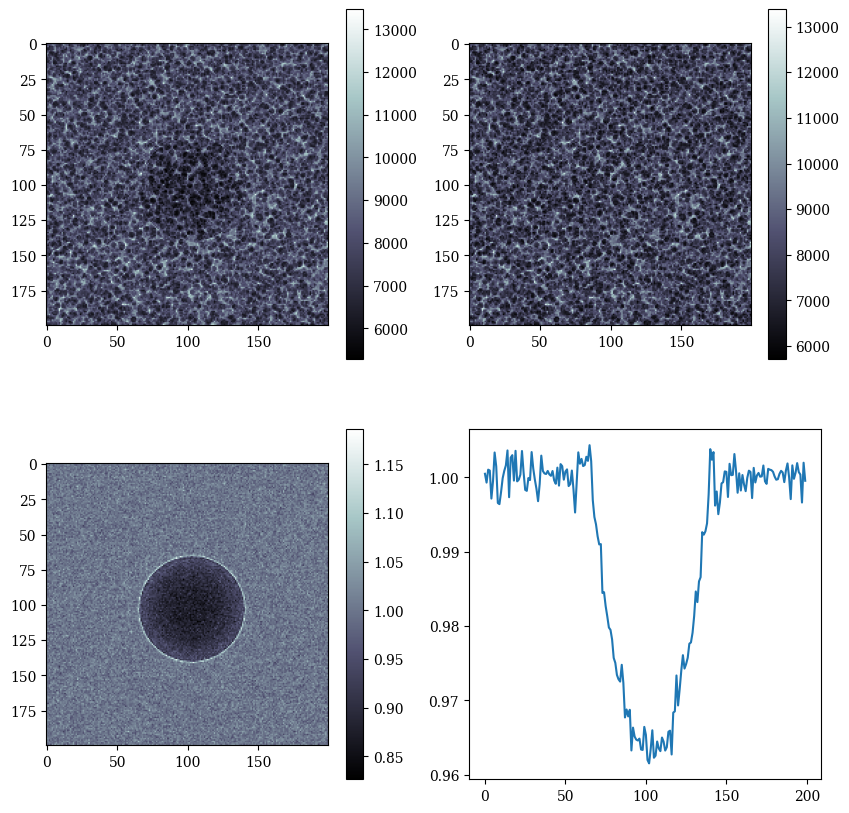

In [5]:
def ImagenesR(name,Npixeles):
    I=[]
    for k in range(0,len(name),Npixeles*Npixeles):
        Im=np.zeros((Npixeles,Npixeles))
        for j in range(Npixeles):
            for i in range(Npixeles):
                Im[j,i]=name[i+Npixeles*j+k]
        I.append(Im)
    return I
def Imagenes(name,Npixeles,NI):
    D=[]
    for i in range(1,NI+1):
        Raw=np.fromfile(name+"{}.raw".format(i), dtype='float32')
        K=ImagenesR(Raw,Npixeles)
        D.append(K)
    return D
def sumar_imagenes(name1, name2, Npixeles):
    # Inicializar una matriz para almacenar la suma de las imágenes
    suma_imagenes = np.zeros((Npixeles, Npixeles), dtype='float32')
    
    # Iterar sobre las imágenes (de R00 a R09)
    for i in range(1,3):  # Cambiado a 10 para incluir R00 a R09
        # Construir el nombre del archivo
        nombre_archivo = f"{name1}{i:01d}{name2}1.raw"
        
        # Leer la imagen desde el archivo .raw
        Raw = np.fromfile(nombre_archivo, dtype='float32')
        
        # Convertir la imagen en una matriz 2D
        K = ImagenesR(Raw, Npixeles)
        
        # Sumar la imagen actual a la suma acumulada
        suma_imagenes += K[0]  # Asumiendo que K[0] es la matriz 2D de la imagen
    
    return suma_imagenes
def Imagenes2(name1, name2, Npixeles, NI):    
    D = []
    for i in range(19):
        Raw = np.fromfile(name1 + "{:02d}".format(i) + name2 + "1.raw", dtype='float32')
        K = ImagenesR(Raw, Npixeles)
        D.append(K[0][25:225,25:225])  # Append the first image in the list to avoid extra dimension
    return D
def ImagenesA(name,Npixeles,NI,NThr):
    A=[]
    for i in range(NThr):
        Mean=np.zeros((Npixeles, Npixeles))
        for j in range (NI):
            Mean=Mean+name[j][i]
        A.append(Mean)
    return A
def CNR(meanS,meanB,stdB):
    CNR = (meanB - meanS)/stdB
    return CNR
'''
def copiar_imagenes(base_name, start, end):
    for i in range(start, end + 1):
        new_name = base_name.replace('TiC3', f'TiC{i}')
        os.system(f'cp {base_name} {new_name}')

    # Uso de la función para copiar la imagen con los nuevos nombres
#base_name = 'TiC_PMMA_4Sands/test_PMMA4_TiC3_19kev_R09__d0.1m_a15um_p62um_step-4.2_dith23.25_1.raw'
#copiar_imagenes(base_name, 3, 10)
'''

RAW = Imagenes2(nameRAW1,nameRAW2,Npixeles,NI)
REF = Imagenes2(nameRAW4,nameRAW2,Npixeles,NI)
REF = np.array(REF)
RAW = np.array(RAW)
RAW.shape,REF.shape
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(RAW[0],cmap='bone')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(REF[0],cmap='bone')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(RAW[18]/REF[18],cmap='bone')
plt.colorbar()
print(RAW.shape,REF.shape)
plt.subplot(2,2,4)
plt.plot(np.mean((RAW[0]/REF[0]),axis=0), label='Profile mean')
#guardar imagenes en formato .txt
np.save("2.5um/RAW.npy", RAW)
np.save("2.5um/REF.npy", REF)



In [6]:
mu_values = []
sigma_values = []

# Iterar sobre las regiones de la imagen en pasos de 50 píxeles
for x in range(0, 250, 50):
    for y in range(0, 250, 50):
        region = REF[0][x:x+50, y:y+50]
        sigma = np.std(region)
        mu = np.mean(region)
        sigma_values.append(sigma)
        mu_values.append(mu)

# Calcular los valores medios de mu y sigma
mean_mu = np.mean(mu_values)
mean_sigma = np.mean(sigma_values)
vis2 = mean_sigma/mean_mu
vis2*100,mean_mu, mean_sigma

/home/c.tibambre/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/c.tibambre/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/c.tibambre/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/c.tibambre/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/c.tibambre/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(nan, nan, nan)

/tmp/ipykernel_2883802/3329350527.py:5: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)  # Ajuste exponencial


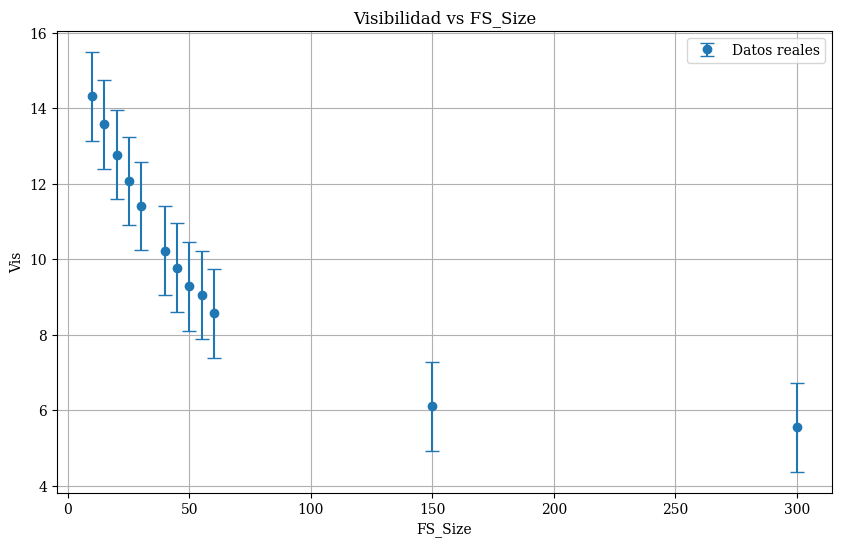

In [96]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def model(x, a, b):
    return a*np.exp(-b*x)  # Ajuste exponencial
def model2(x, a2, b2):
    return -a2*x +b2


Vis = np.array([14.32,13.58,12.77,12.07,11.41, 10.23,9.77,9.28, 9.05,8.57,6.10,5.54])
FS_Size = np.array([10, 15, 20, 25, 30, 40, 45, 50, 55,60,150,300])
params, covariance = curve_fit(model, FS_Size, Vis)
params2, covariance2 = curve_fit(model2, FS_Size, Vis)
a, b = params
a2, b2 = params2

perr = np.sqrt(np.diag(covariance))  # Desviaciones estándar de los parámetros
perr2 = np.sqrt(np.diag(covariance2))  # Desviaciones estándar de los parámetros del segundo modelo
x_fit = np.linspace(FS_Size.min(), FS_Size.max(), 100)
x_fit2 = np.linspace(FS_Size.min(), FS_Size.max(), 100)
y_fit = model(x_fit, a, b)
y_fit2 = model2(x_fit2, a2, b2)
residual2 = Vis - model(FS_Size, a, b)
ss_res = np.sum(residual2**2)
ss_tot = np.sum((Vis - np.mean(Vis))**2)
r_squared = 1 - (ss_res / ss_tot)

# Error estimado (desviación estándar de los residuos)
error_estimado = np.std(residual2)
#r2_score2 = r2_score(Vis, model2(FS_Size, a2, b2))
plt.figure(figsize=(10, 6))
plt.errorbar(FS_Size, Vis, yerr=error_estimado, fmt='o', label='Datos reales', capsize=5)  # Asumí un error de 0.2 en Vis, ajusta según necesidad
#plt.plot(x_fit, y_fit, 'r-', label=f'Ajuste: $y = {a:.2f}/x + {b:.2f}$')
#plt.plot(x_fit2, y_fit, 'b--', label=f'Ajuste: $y = -{a2:.2f}*e ^{b2:.2f}^x$ y R² = {r_squared:.2f}')
plt.xlabel('FS_Size')
plt.ylabel('Vis')
plt.title('Visibilidad vs FS_Size')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
for i in range(7):
    np.savetxt(f"FS_Measurements_txt_Files/RAW_SiC_60um_FS300um_21kev_2x150_75_AIR_0{i}.txt", RAW[i], fmt='%f')
    np.savetxt(f"FS_Measurements_txt_Files/REF_SiC_60um_FS300um_21kev_2x150_75_AIR_0{i}.txt", REF[i], fmt='%f')
    np.savetxt(f"FS_Measurements_txt_Files/Ratio_SiC_60um_FS300um_21kev_2x150_75_AIR_0{i}_profile.txt", np.mean((RAW[i]/REF[i]),axis=0), fmt='%f')

Using 16 threads
Using 16 threads
(190, 190)


/tmp/ipykernel_3018469/744699277.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,1)


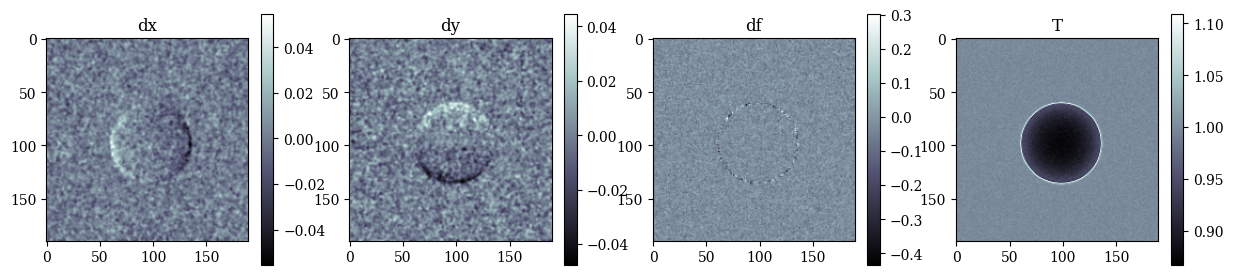

In [6]:
import UMPA
I_ref,Isamp = [],[]
FS_Size = 300
#for i in range(7):
    #I_ref.append(np.loadtxt(f"FS_Measurements_txt_Files/REF_SiC_60um_FS{FS_Size}um_21kev_2x150_75_AIR_0{i}.txt"))#Nylon_TxT_Files/RAW_SiC_F85D15_3x_Poli_00.txt
    #Isamp.append(np.loadtxt(f"FS_Measurements_txt_Files/RAW_SiC_60um_FS{FS_Size}um_21kev_2x150_75_AIR_0{i}.txt"))
ref = REF # Establishing empty arrays to put SB-PCXI data into
sam = RAW#np.load(f"DATA_Prosesada_14.75keV/RAW_FF_14.75keV.npy")


UMPA_res2 = UMPA.match(sam, ref, 1,max_shift=10) # provide sample and reference images in input to #UMPA, 3 is the window size (user defined)
UMPA_bias2 = UMPA.match(ref, ref, 1,max_shift=10) # UMPA sometimes can output images with a #sistematic bias: you can compute this by taking UMPA result from ref Vs ref
#UMPA_res2 = UMPA.match(np.expand_dims(sam[0],axis=0), np.expand_dims(ref[0],axis=0), 4,max_shift=10) # provide sample and reference images in input to #UMPA, 3 is the window size (user defined)
#UMPA_bias2 = UMPA.match(np.expand_dims(ref[0],axis=0), np.expand_dims(ref[0],axis=0), 4,max_shift=10) 
def inverse_grad(grad_x: np.ndarray, grad_y: np.ndarray, epsilon: float = 1e-6) -> np.ndarray:
    """
    Reconstruye la fase (phi_UMPA) a partir de los gradientes (grad_x, grad_y).
    Basado en la ecuación de Poisson: ∇²ϕ = ∇·G, donde G = (grad_x, grad_y).
    """
    rows, cols = grad_x.shape
    ky, kx = np.mgrid[-rows//2:rows//2, -cols//2:cols//2]
    kx = (2 * np.pi * kx) / cols
    ky = (2 * np.pi * ky) / rows

    # Divergencia del campo de gradientes (∇·G)
    div_G = np.fft.fft2(grad_x) * 1j * kx + np.fft.fft2(grad_y) * 1j * ky

    # Resuelve la ecuación de Poisson en espacio Fourier (evita división por cero)
    kernel = kx**2 + ky**2 + epsilon
    kernel[kernel == 0] = epsilon  # Regularización
    phi_fft = div_G / kernel

    # Transformada inversa para obtener la fase reconstruida
    phi_UMPA = np.fft.ifft2(phi_fft).real
    return phi_UMPA 
phi = inverse_grad(UMPA_res2['dx'], UMPA_res2['dy'],epsilon=1e-4)
print(phi.shape)
#guardar imagenes en formato .txt
dx = UMPA_res2['dx']-UMPA_bias2['dx']
np.savetxt(f'FS_Measurements_txt_Files/dx_SiC_60um_FS{FS_Size}um_21kev_2x150_75_AIR.txt', dx, fmt='%f')
dy = UMPA_res2['dy']-UMPA_bias2['dy']
np.savetxt(f'FS_Measurements_txt_Files/dy_SiC_60um_FS{FS_Size}um_21kev_2x150_75_AIR.txt', dy, fmt='%f')
df = UMPA_res2['df']-UMPA_bias2['df']
T = UMPA_res2['T']
np.savetxt(f'FS_Measurements_txt_Files/T_SiC_60um_FS{FS_Size}um_21kev_2x150_75_AIR.txt', T, fmt='%f')
from scipy.ndimage import gaussian_filter
dx = gaussian_filter(dx, sigma=1)  # Aplicar filtro gaussiano para suavizar
dy = gaussian_filter(dy, sigma=1)  # Aplicar filtro gaussiano

#np.savetxt("Golden_Results/dx_TiC_90um_19k_PMMA.txt", dx)
#np.savetxt("Golden_Results/dy_TiC_90um_19k_PMMA.txt", dy)

plt.figure(figsize=(15,15))
plt.title('UMPA results at 19kev and 1e9 events')
plt.subplot(4,4,1)
plt.imshow(dx,cmap='bone') #here subtract bias to the result -UMPA_bias['dx']
#np.savetxt('dx_4_90.txt', UMPA_res['dx']-UMPA_bias['dx'])
plt.title('dx')
plt.colorbar()
plt.subplot(4,4,2)
plt.imshow(dy,cmap='bone') #-UMPA_bias['dy']
plt.title('dy')
#np.savetxt('dy_4_90.txt', UMPA_res['dy']-UMPA_bias['dy'])
plt.colorbar()
plt.subplot(4,4,3)
plt.imshow(df,cmap='bone') #-UMPA_bias['T']
plt.title('df')  
plt.colorbar()
plt.subplot(4,4,4)
plt.imshow(T,cmap='bone') #-UMPA_bias['T']
plt.title('T')  
plt.colorbar()


In [57]:
#guardar imagenes en formato .txt
np.savetxt(f"{FS_Size}um/df.txt", df, fmt='%f')
np.savetxt(f"{FS_Size}um/T.txt", T, fmt='%f')
np.savetxt(f"{FS_Size}um/dx.txt", dx, fmt='%f')
np.savetxt(f"{FS_Size}um/dy.txt", dy, fmt='%f')

In [10]:

from skimage.transform import warp_polar
from skimage.io import imread
from skimage.color import rgb2gray

img = dx
if img.ndim == 3:
    img = rgb2gray(img)

center = (img.shape[0] // 2, img.shape[1] // 2)

polar_img = warp_polar(img, center=center, radius=img.shape[0]//2)

perfil_radial = np.mean(polar_img, axis=1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


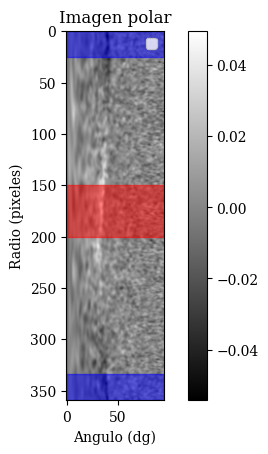

In [11]:
plt.imshow(polar_img, cmap='gray') 
#plt.axhspan(y=polar_img.shape[0]//2.4, color='r', linestyle='--', label='Centro') 
#pintar un axhspan entre 150 a 200 pixeles
plt.axhspan(150, 200, color='r',alpha=0.5)
plt.axhspan(0,25, color ='b',alpha=0.5)
plt.axhspan(334, 359, color ='b',alpha=0.5)
plt.title("Imagen polar")
plt.xlabel("Angulo (dg)")
plt.ylabel("Radio (pixeles)")
plt.colorbar()  
plt.legend()

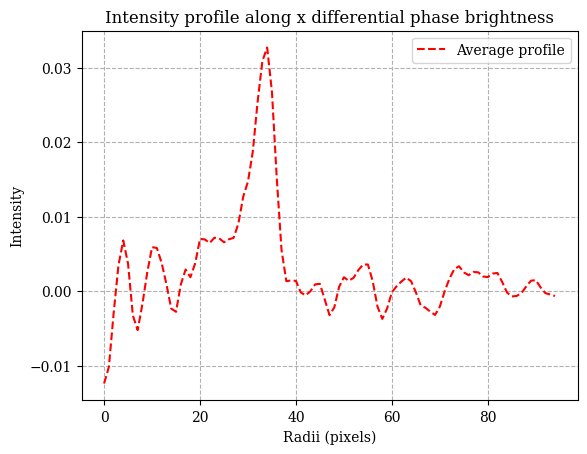

El pico de la intensidad se encuentra en el radio: 34 pixeles con un valor de: 0.03268614592478367


In [12]:
#Tomemos 20 perfiles entre 150 px a 200 px a lo largo de x
perfil = []
for i in range(150, 200,2):
    perfil.append(polar_img[i,:])
mean_Profile = np.mean(perfil, axis=0)
plt.plot(mean_Profile, label='Average profile', color='red',linestyle='--')
plt.title("Intensity profile along x differential phase brightness")
plt.xlabel("Radii (pixels)")
plt.ylabel("Intensity")
plt.grid(linestyle='--')
plt.legend()
plt.show()
peak = np.argmax(mean_Profile)
peak_value_max = mean_Profile[peak]
print(f"El pico de la intensidad se encuentra en el radio: {peak} pixeles con un valor de: {peak_value_max}")


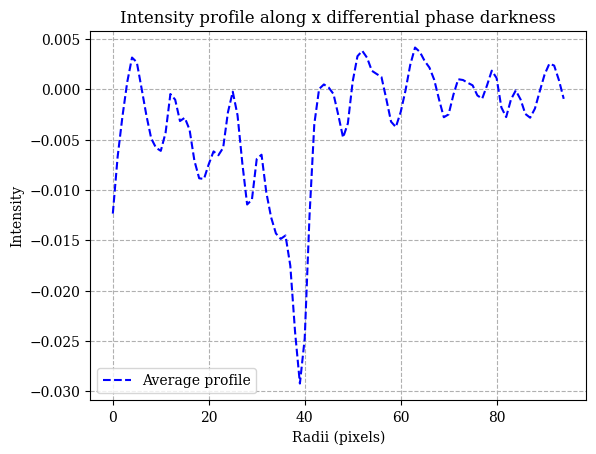

El pico de la intensidad se encuentra en el radio: 39 pixeles con un valor de: -0.029248345094605825


In [13]:
#Tomemos 20 perfiles entre 150 px a 200 px a lo largo de x
perfil2 = []
perfil3 = []
for i in range(0, 25,2):
    for j in range(334, 359,2):
        perfil2.append(polar_img[i,:])
        perfil3.append(polar_img[j,:])
perfil = perfil2 + perfil3
mean_Profile = np.mean(perfil, axis=0)
plt.plot(mean_Profile, label='Average profile', color='blue',linestyle='--')
plt.title("Intensity profile along x differential phase darkness")
plt.xlabel("Radii (pixels)")
plt.ylabel("Intensity")
plt.grid(linestyle='--')
plt.legend()
plt.show()
peak = np.argmin(mean_Profile)
peak_value_min = mean_Profile[peak]
print(f"El pico de la intensidad se encuentra en el radio: {peak} pixeles con un valor de: {peak_value_min}")

In [14]:
Contrast = peak_value_max - peak_value_min
print(f"El contraste entre el pico máximo y mínimo es: {Contrast}")
std_x = np.std(dx[0:50,0:50])
std_y = np.std(dy[0:50,0:50])
SNR_x = Contrast/std_x
print(f"El SNR en x es: {SNR_x}")

El contraste entre el pico máximo y mínimo es: 0.0619344910193895
El SNR en x es: 8.213623542647234


In [34]:
def phaseint_fourier(dpc_row, dpc_col):
    """
    Implements fourier integration method for two differential quantities.

    Assumes 2 N-dimensional arrays which contain differential quantities
    in the LAST two dimensions (-2 & -1).
    Note that the input arrays are numerical derivatives (i.e., the
    difference of adjacent pixel values), not physical derivatives (d/dx).
    In other words, this function is equivalent to numerical integration,
    similar to `np.cumsum()`.

    Parameters
    ----------
    dpc_row : ndarray
        Partial derivative of image along second-to-last axis
        (i.e., axis 0 for a 2d input, "np.diff(img, 0)").
    dpc_col : ndarray
        Partial derivative of image along last axis
        (i.e., axis 1 for a 2d input, "np.diff(img, 1)").
        Must have same shape as `dpc_row`.
        
    Returns
    -------
    img : ndarray
        Integrated image, i.e., the array `img` for which
        `dpc_row = np.diff(img, 0)` and
        `dpc_col = np.diff(img, 1)` (except that the output of
        `np.diff()` is one pixel smaller than its input, whereas `img`
        has the same shape as `dpc_row` and `dpc_col`).
    """
    import numpy as np
    
    py = dpc_row
    px = dpc_col
    sh = px.shape
    sh = np.asarray(sh)
    fac = np.ones_like(sh)
    fac[-2:] = 2
    f = np.zeros(sh * fac, dtype=complex)
    f[..., :sh[-2], :sh[-1]] = -px[..., ::-1, ::-1] - 1j*py[..., ::-1, ::-1]
    f[..., :sh[-2], sh[-1]:] = -px[..., ::-1, :] + 1j*py[..., ::-1, :]
    f[..., sh[-2]:, :sh[-1]] = px[..., :, ::-1] - 1j*py[..., :, ::-1]
    f[..., sh[-2]:, sh[-1]:] = px + 1j*py
    qy = 2*np.pi*np.fft.fftfreq(f.shape[1]).reshape((1, -1)) # horizontal
    qx = 2*np.pi*np.fft.fftfreq(f.shape[0]).reshape((-1, 1)) # vertical
    qy[0,0] = qx[0,0] = 1e-6
    inv_qc = 1. / (1j*(qx + 1j*qy))
    inv_qc[..., 0, 0] = 0
    nf = np.fft.ifft2(np.fft.fft2(f) * inv_qc)

    return np.real(nf[..., sh[-2]:, sh[-1]:])

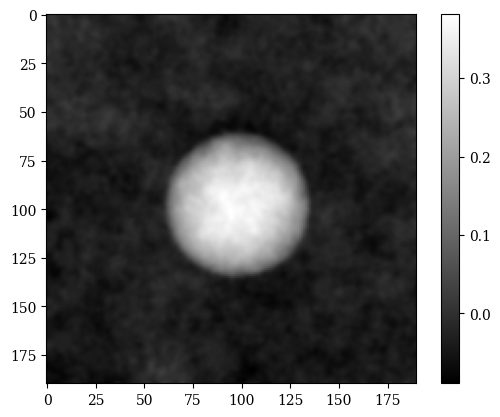

In [35]:
phaseint_fourier(dx, dy)
phi_UMPA = phaseint_fourier(dx, dy)
plt.imshow(phi_UMPA, cmap='gray')
plt.colorbar()

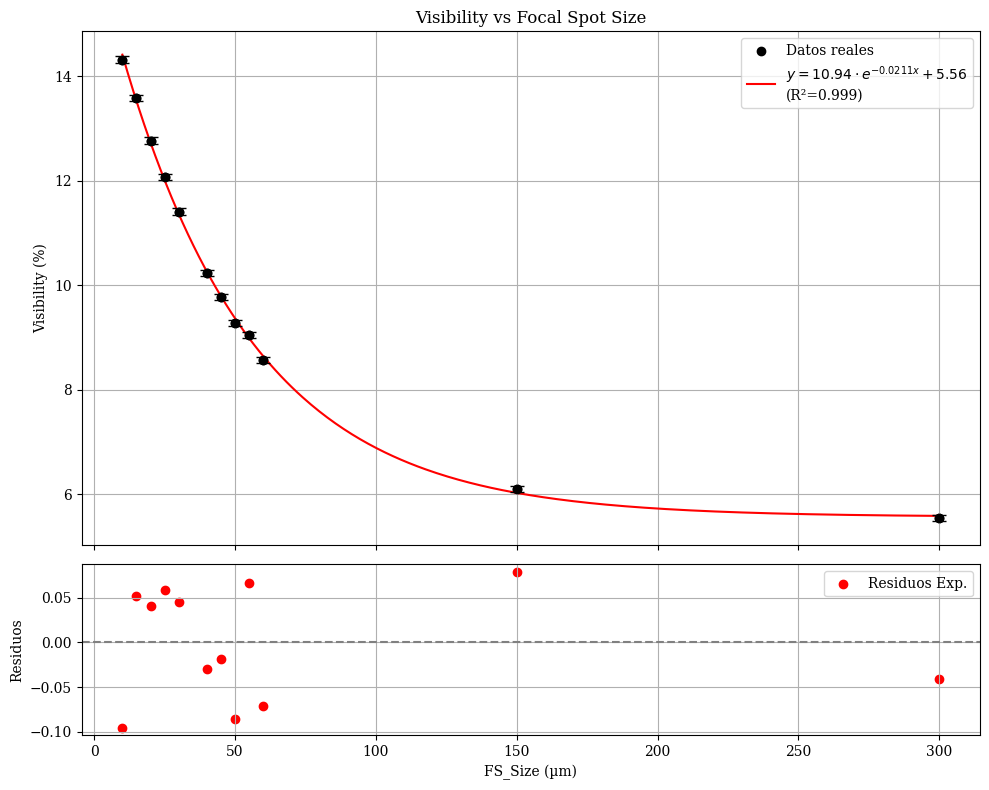

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Modelo exponencial con término constante
def model_exp(x, a, b, c):
    return a * np.exp(-b * x) + c  

# Modelo lineal
def model_lin(x, a2, b2):
    return -a2 * x + b2        

# Datos
Vis = np.array([14.32, 13.58, 12.77, 12.07, 11.41, 10.23, 9.77, 9.28, 9.05, 8.57, 6.10, 5.54])
FS_Size = np.array([10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 150, 300])

# Ajuste de modelos
params_exp, covariance_exp = curve_fit(model_exp, FS_Size, Vis, p0=(15, 0.01, 5))  
params_lin, covariance_lin = curve_fit(model_lin, FS_Size, Vis)

a, b, c = params_exp
a2, b2 = params_lin

# Ajustes
x_fit = np.linspace(FS_Size.min(), FS_Size.max(), 300)
y_fit_exp = model_exp(x_fit, a, b, c)
y_fit_lin = model_lin(x_fit, a2, b2)

# Residuos
residuals_exp = Vis - model_exp(FS_Size, a, b, c)

# Métrica R²
ss_res = np.sum(residuals_exp**2)
ss_tot = np.sum((Vis - np.mean(Vis))**2)
r2_exp = 1 - (ss_res / ss_tot)

# ----------- Gráfico principal + distribución de errores -------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Gráfico con datos y ajustes
ax1.scatter(FS_Size, Vis, label="Datos reales", color="black")

# ✅ Aquí insertamos la ecuación con los parámetros en el legend
fit_equation = f"$y = {a:.2f} \cdot e^{{-{b:.4f}x}} + {c:.2f}$\n(R²={r2_exp:.3f})"
ax1.plot(x_fit, y_fit_exp, 'r-', label=fit_equation)

# Barras de error
error_estimado = np.std(residuals_exp)
ax1.errorbar(FS_Size, Vis, yerr=error_estimado, fmt="o", color="black", capsize=5)

ax1.set_ylabel("Visibility (%)")
ax1.set_title("Visibility vs Focal Spot Size")
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color="gray", linestyle="--")
ax2.scatter(FS_Size, residuals_exp, color="red", label="Residuos Exp.")
ax2.set_xlabel("FS_Size (µm)")
ax2.set_ylabel("Residuos")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


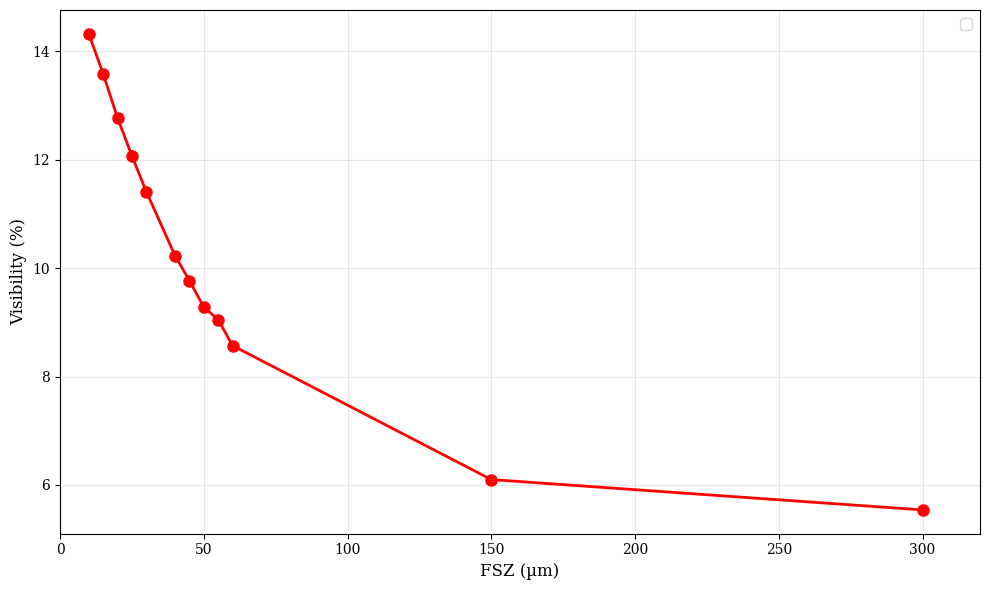

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Datos
Vis = np.array([14.32, 13.58, 12.77, 12.07, 11.41, 10.23, 9.77, 9.28, 9.05, 8.57, 6.10, 5.54])
FS_Size = np.array([10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 150, 300])

# Crear figura
plt.figure(figsize=(10, 6))

# Graficar puntos y línea de tendencia roja que los conecta
plt.plot(FS_Size, Vis, 'ro-', linewidth=2, markersize=8)

# Configuración del gráfico
plt.xlabel("FSZ (µm)", fontsize=12)
plt.ylabel("Visibility (%)", fontsize=12)
#plt.title("Visibilidad vs Tamaño de Foco", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Ajustar los límites del eje x para mejor visualización
plt.xlim(0, 320)

plt.tight_layout()
plt.savefig("Visibility_vs_Focal_Spot_Size.png", dpi=300)
plt.show()

In [63]:
SNR = np.array([13.58, 11.19, 4.4, 2.28, 1.29])
FSZ = np.array([2.5, 15, 50, 100, 300])


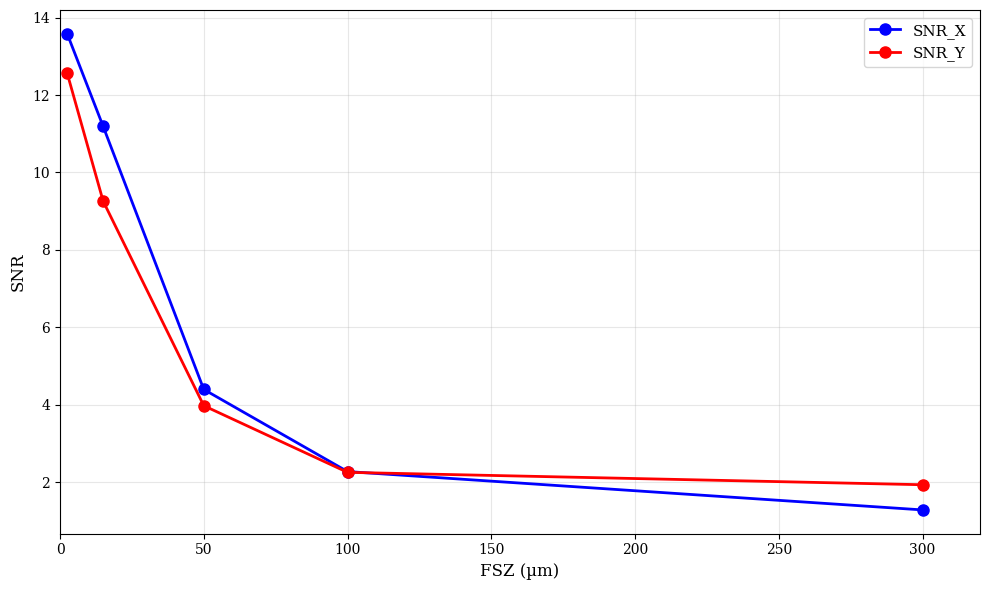

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Datos
SNR = np.array([13.58, 11.19, 4.4, 2.28, 1.29])
SNR_y = [12.56,9.26, 3.98, 2.26, 1.94]
FSZ = np.array([2.5, 15, 50, 100, 300])

# Crear figura
plt.figure(figsize=(10, 6))

# Graficar puntos y línea de tendencia roja que los conecta
plt.plot(FSZ, SNR, 'bo-', linewidth=2, markersize=8,label='SNR_X')
plt.plot(FSZ, SNR_y, 'ro-', linewidth=2, markersize=8,label='SNR_Y')

# Configuración del gráfico
plt.xlabel("FSZ (µm)", fontsize=12)
plt.ylabel("SNR", fontsize=12)
#plt.title("Visibilidad vs Tamaño de Foco", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Ajustar los límites del eje x para mejor visualización
plt.xlim(0, 320)

plt.tight_layout()
plt.savefig("SNR_X_vs_Focal_Spot_Size.png", dpi=300)
plt.show()

In [65]:
dx_2_um  = np.loadtxt("2.5um/dx.txt")
dy_2_um  = np.loadtxt("2.5um/dy.txt")
T_2_um   = np.loadtxt("2.5um/T.txt")
df_2_um  = np.loadtxt("2.5um/df.txt")
dx_300_um = np.loadtxt("300um/dx.txt")
dy_300_um = np.loadtxt("300um/dy.txt")
T_300_um  = np.loadtxt("300um/T.txt")
df_300_um = np.loadtxt("300um/df.txt")  
dx_15_um = np.loadtxt("15um/dx.txt")
dy_15_um = np.loadtxt("15um/dy.txt")
T_15_um  = np.loadtxt("15um/T.txt")
df_15_um = np.loadtxt("15um/df.txt")
dx_50_um = np.loadtxt("50um/dx.txt")
dy_50_um = np.loadtxt("50um/dy.txt")
T_50_um  = np.loadtxt("50um/T.txt")
df_50_um = np.loadtxt("50um/df.txt")
dx_100_um = np.loadtxt("100um/dx.txt")
dy_100_um = np.loadtxt("100um/dy.txt")
T_100_um  = np.loadtxt("100um/T.txt")
df_100_um = np.loadtxt("100um/df.txt")


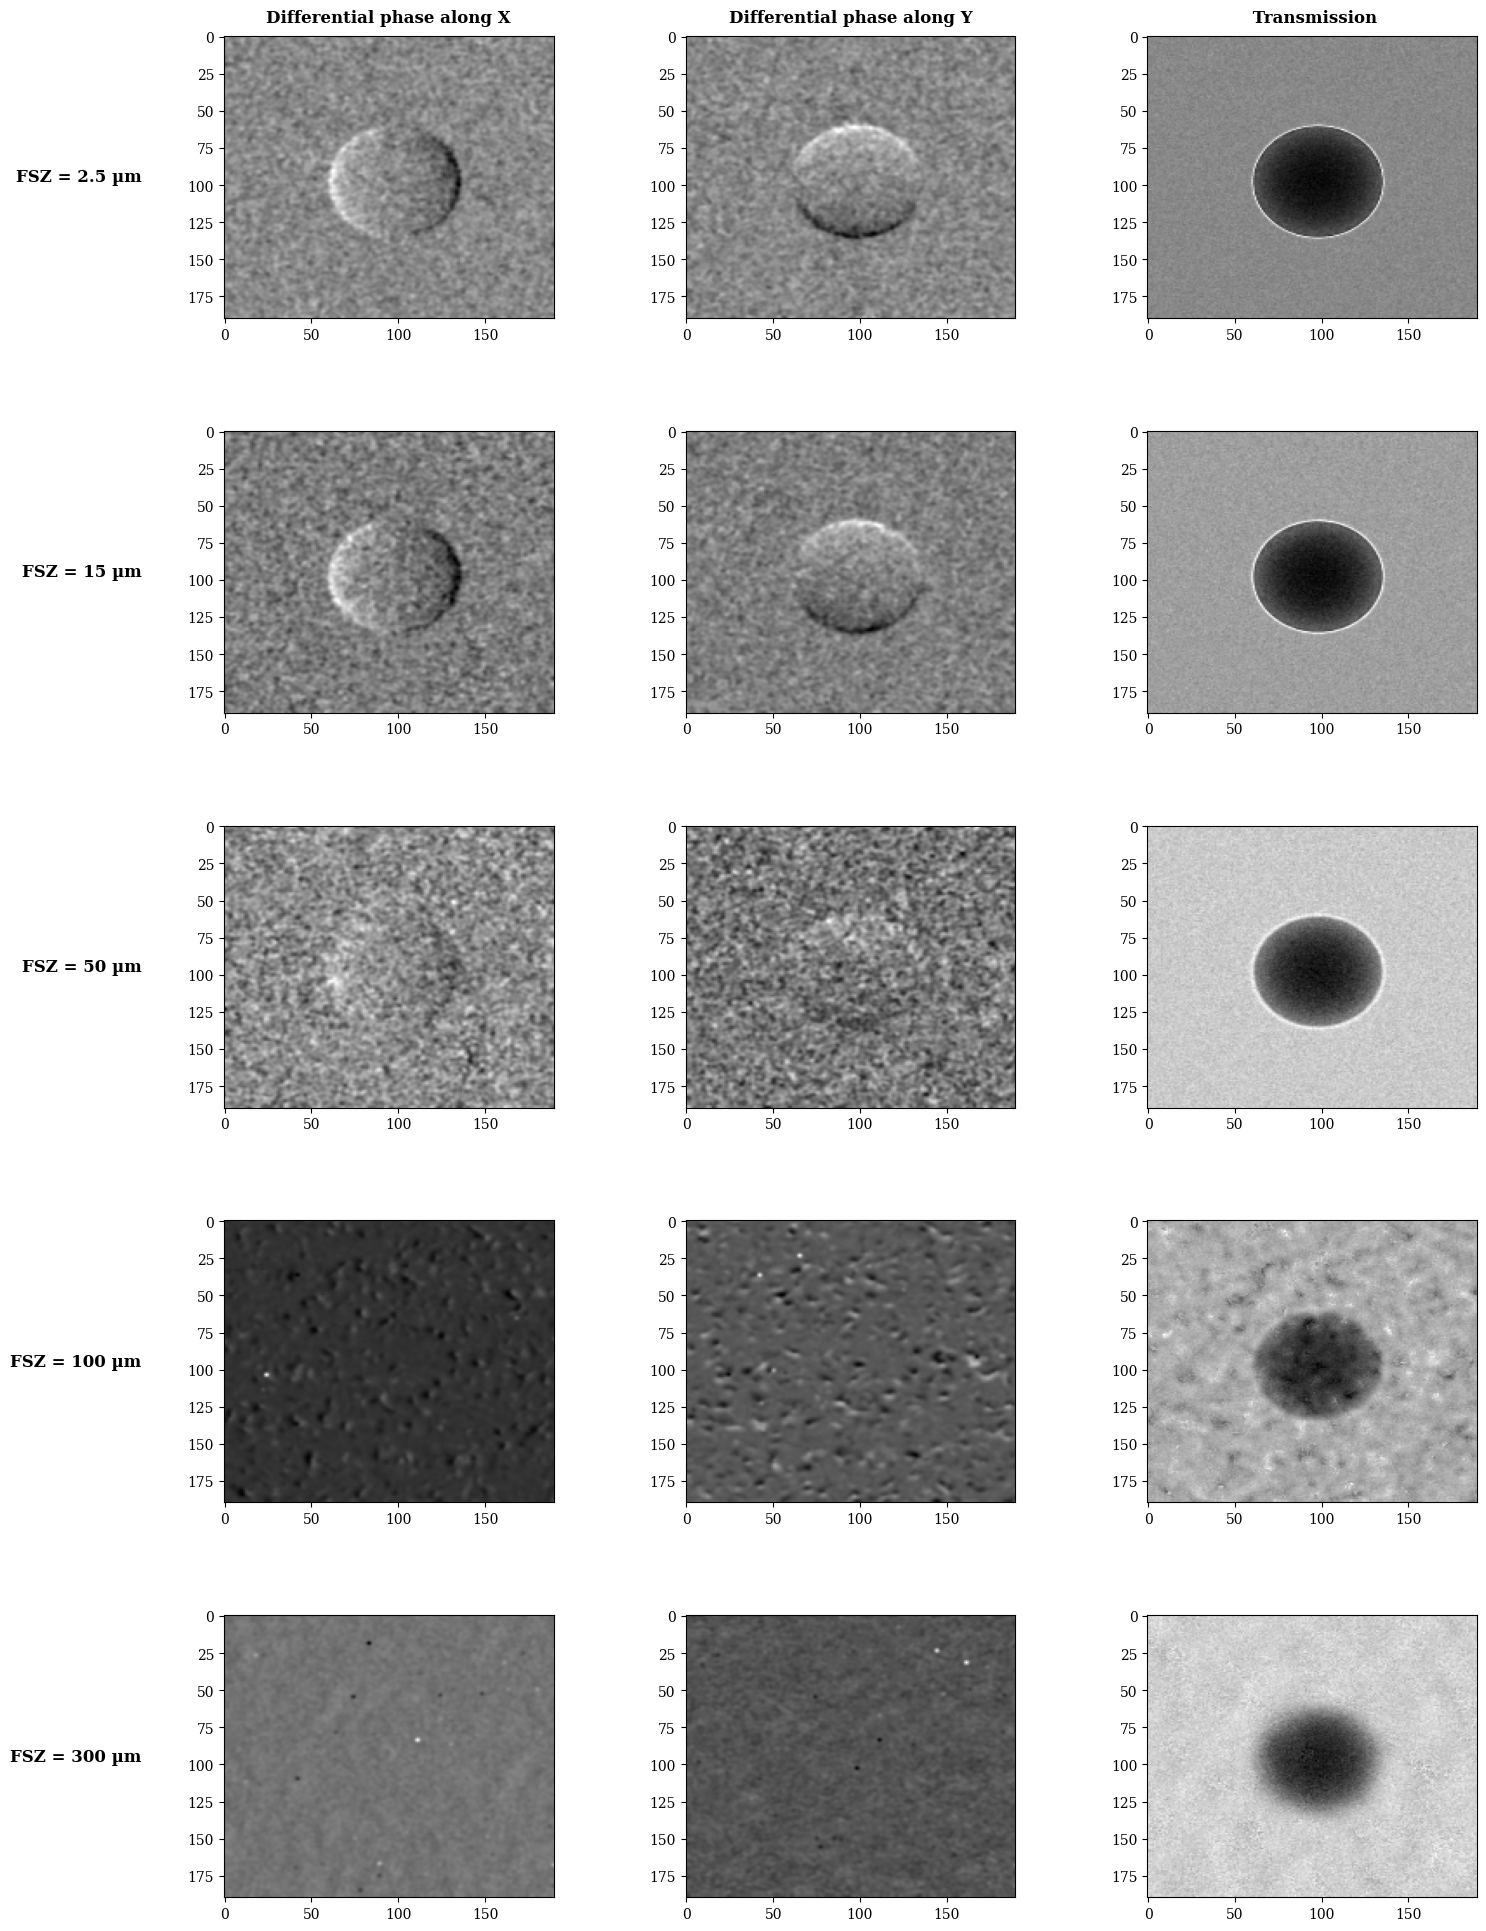

In [120]:
# Supongamos que ya tienes tus matrices cargadas en variables
# dx_2, dy_2, T_2, dx_15, dy_15, T_15, etc.

# Configuración de la figura
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
#fig.suptitle('Análisis de datos por tamaño de foco (FSZ)', fontsize=16, fontweight='bold')

# Lista de tamaños de foco para cada fila
fsz_labels = ['FSZ = 2.5 µm', 'FSZ = 15 µm', 'FSZ = 50 µm', 'FSZ = 100 µm', 'FSZ = 300 µm']

# Títulos para las columnas
column_titles = ['Differential phase along X', 'Differential phase along Y', ' Transmission']

# Organiza tus matrices en una estructura de 5x3
# (Asumiendo que tienes 15 matrices con los nombres sugeridos)
matrices = [
    [dx_2_um, dy_2_um, T_2_um],      # Fila 1
    [dx_15_um, dy_15_um, T_15_um],   # Fila 2     # Fila 3
    [dx_50_um, dy_50_um, T_50_um],   # Fila 3
    [dx_100_um, dy_100_um, T_100_um], # Fila 4
    [dx_300_um, dy_300_um, T_300_um] # Fila 5
]

# Visualizar las matrices
for i in range(5):  # 5 filas
    for j in range(3):  # 3 columnas
        # Obtener la matriz correspondiente
        matriz = matrices[i][j]
        
        # Visualizar según la dimensión de la matriz
        if matriz.ndim == 2:
            # Matriz 2D: mostrar como imagen
            im = axes[i, j].imshow(matriz, cmap='gray', aspect='auto')
            
            # Añadir barra de color para cada subplot
            #plt.colorbar(im, ax=axes[i, j], shrink=0.8)
            
        elif matriz.ndim == 1:
            # Vector 1D: mostrar como gráfico de línea
            axes[i, j].plot(matriz)
            axes[i, j].set_ylim(matriz.min() * 0.9, matriz.max() * 1.1)
        
        # Añadir título de columna solo en la primera fila
        if i == 0:
            axes[i, j].set_title(column_titles[j], fontsize=12, fontweight='bold', pad=10)

    # Añadir etiqueta FSZ al lado izquierdo de cada fila
    axes[i, 0].text(-0.25, 0.5, fsz_labels[i], transform=axes[i, 0].transAxes, 
                   fontsize=12, fontweight='bold', va='center', ha='right')

# Ajustar espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace=0.4, hspace=0.4)
plt.savefig("Combined_Analysis_FSZ.png", dpi=300)
plt.show()

## Analsis para el caso en Y

In [110]:

from skimage.transform import warp_polar
from skimage.io import imread
from skimage.color import rgb2gray

img = dy_100_um
if img.ndim == 3:
    img = rgb2gray(img)

center = (img.shape[0] // 2, img.shape[1] // 2)

polar_img = warp_polar(img, center=center, radius=img.shape[0]//2)

perfil_radial = np.mean(polar_img, axis=1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


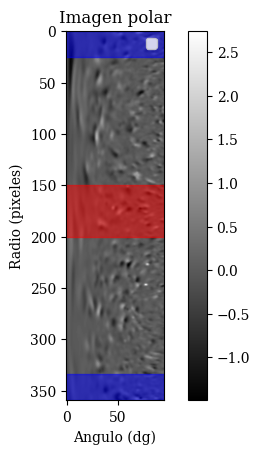

In [111]:
plt.imshow(polar_img, cmap='gray') 
#plt.axhspan(y=polar_img.shape[0]//2.4, color='r', linestyle='--', label='Centro') 
#pintar un axhspan entre 150 a 200 pixeles
plt.axhspan(150, 200, color='r',alpha=0.5)
plt.axhspan(0,25, color ='b',alpha=0.5)
plt.axhspan(334, 359, color ='b',alpha=0.5)
plt.title("Imagen polar")
plt.xlabel("Angulo (dg)")
plt.ylabel("Radio (pixeles)")
plt.colorbar()  
plt.legend()

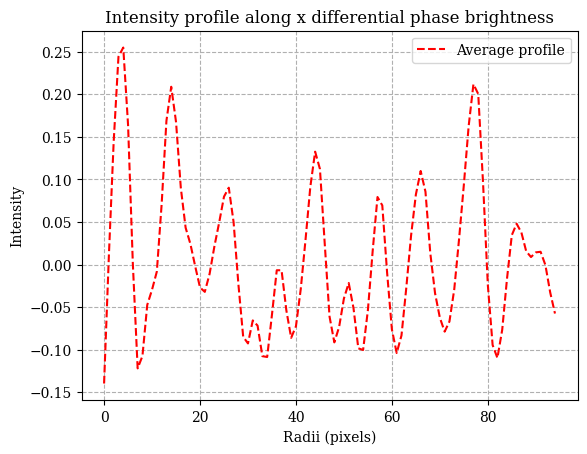

El pico de la intensidad se encuentra en el radio: 4 pixeles con un valor de: 0.2549832535597566


In [112]:
#Tomemos 20 perfiles entre 150 px a 200 px a lo largo de x
perfil = []
for i in range(200, 250,2):
    perfil.append(polar_img[i,:])
mean_Profile = np.mean(perfil, axis=0)
plt.plot(mean_Profile, label='Average profile', color='red',linestyle='--')
plt.title("Intensity profile along x differential phase brightness")
plt.xlabel("Radii (pixels)")
plt.ylabel("Intensity")
plt.grid(linestyle='--')
plt.legend()
plt.show()
peak = np.argmax(mean_Profile)
peak_value_max = mean_Profile[peak]
print(f"El pico de la intensidad se encuentra en el radio: {peak} pixeles con un valor de: {peak_value_max}")


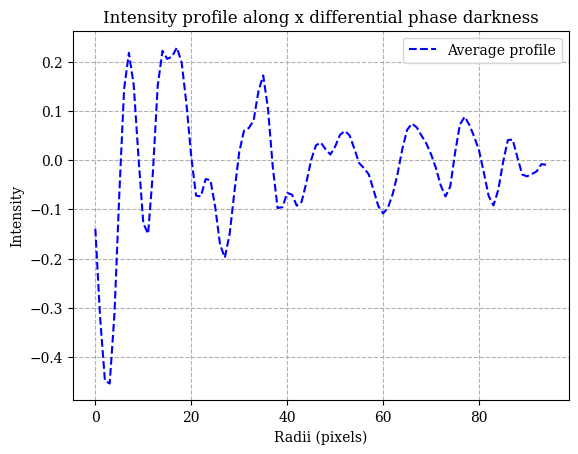

El pico de la intensidad se encuentra en el radio: 3 pixeles con un valor de: -0.45432240433455556


In [113]:
#Tomemos 20 perfiles entre 150 px a 200 px a lo largo de x
perfil2 = []
perfil3 = []
for i in range(50, 75,2):
    for j in range(75, 100,2):
        perfil2.append(polar_img[i,:])
        perfil3.append(polar_img[j,:])
perfil = perfil2 + perfil3
mean_Profile = np.mean(perfil, axis=0)
plt.plot(mean_Profile, label='Average profile', color='blue',linestyle='--')
plt.title("Intensity profile along x differential phase darkness")
plt.xlabel("Radii (pixels)")
plt.ylabel("Intensity")
plt.grid(linestyle='--')
plt.legend()
plt.show()
peak = np.argmin(mean_Profile)
peak_value_min = mean_Profile[peak]
print(f"El pico de la intensidad se encuentra en el radio: {peak} pixeles con un valor de: {peak_value_min}")

In [114]:
Contrast = peak_value_max - peak_value_min
print(f"El contraste entre el pico máximo y mínimo es: {Contrast}")
std_x = np.std(dx[0:50,0:50])
std_y = np.std(dy_100_um[0:50,0:50])
SNR_x = Contrast/std_x
SNR_y = Contrast/std_y
print(f"El SNR en x es: {SNR_x}")
print(f"El SNR en y es: {SNR_y}")

El contraste entre el pico máximo y mínimo es: 0.7093056578943122
El SNR en x es: 1.5395983048939685
El SNR en y es: 3.2612229623387243


In [115]:
SNR_y = [12.56,9.26, 3.98, 2.26, 1.94]